In [1]:
using JWAS,CSV,DataFrames,LinearAlgebra,Statistics,Random,DelimitedFiles
using Distributions
using Printf

In [2]:
phenofile  = "phenotypes.txt"
genofile   = "genotypes.txt"
df = readtable(genofile,header=false)
headerMarkers = [df[1,i] for i=2:size(df,2)]
id = string.(df[2:end,1]);

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = ip:0x0
└ @ Core :-1


In [3]:
M=convert(Array{Float64,2},readtable(genofile)[:,2:end])
phenotypes = readtable(phenofile);

┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = top-level scope at In[3]:1
└ @ Core In[3]:1
┌ Warning: indexing with colon as row will create a copy in the future use df[col_inds] to get the columns without copying
│   caller = top-level scope at In[3]:1
└ @ Core In[3]:1
┌ Warning: readtable is deprecated, use CSV.read from the CSV package instead
│   caller = top-level scope at In[3]:2
└ @ Core In[3]:2


In [4]:
head(phenotypes)

6×5 DataFrame
│ Row │ id     │ y1        │ y2        │ y3        │ y4        │
│     │ Int64⍰ │ Float64⍰  │ Float64⍰  │ Float64⍰  │ Float64⍰  │
├─────┼────────┼───────────┼───────────┼───────────┼───────────┤
│ 1   │ 1      │ 1.67163   │ -1.72747  │ -1.89028  │ 0.0509159 │
│ 2   │ 2      │ -0.252703 │ 0.409522  │ 0.309386  │ -1.73876  │
│ 3   │ 3      │ 0.341815  │ -0.648626 │ -0.799559 │ -1.05357  │
│ 4   │ 4      │ 0.785439  │ 0.0939492 │ 0.570468  │ 0.551757  │
│ 5   │ 5      │ 0.998318  │ -0.282481 │ 1.61868   │ -0.114285 │
│ 6   │ 6      │ 2.3361    │ 0.626476  │ 0.0735331 │ 0.719586  │

In [5]:
mStd = std(M,dims=1)
M = M ./ mStd;

In [6]:
var(M,dims=1)

1×1279 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [7]:
function getTrnValSets(N,trnSize)
    # N is the size of the data set
    trnSet = sort(sample(1:N,trnSize,replace=false))
    mask = trues(N)
    mask[trnSet] .= false
    valSet = (1:N)[mask]
    return trnSet,valSet
end

getTrnValSets (generic function with 1 method)

The "sample" function can be used to get a random sample from and array of objects. Some examples:

In [8]:
sample([45,"a",1,1,2,2,3],5,replace=false)

5-element Array{Any,1}:
 2   
 3   
 1   
 1   
  "a"

In [9]:
sample(1:8,5,replace=false)

5-element Array{Int64,1}:
 2
 4
 7
 5
 3

In [10]:
getTrnValSets(10,5)

([2, 4, 6, 7, 10], [1, 3, 5, 8, 9])

In [12]:
trn, val = getTrnValSets(10,5)
trn

5-element Array{Int64,1}:
 1
 2
 4
 7
 9

In [13]:
val

5-element Array{Int64,1}:
  3
  5
  6
  8
 10

In [14]:
res = getTrnValSets(10,5)
res[1]

5-element Array{Int64,1}:
  4
  6
  8
  9
 10

In [17]:
res[2] 

5-element Array{Int64,1}:
 1
 2
 3
 5
 7

In [19]:
model_equation = "y1 = intercept
                  y2 = intercept"

R     = [0.5301922 -0.2248727
        -0.2248727  0.5724733]

G = [ 3.462704e-05 -2.076392e-05
     -2.076392e-05  3.059811e-05] .* 12


trnSize = 300
N = size(phenotypes,1)
resFile = open("wheatCorrelations","w")

IOStream(<file wheatCorrelations>)

In [20]:
for i=1:10
    println("\n Iteration: ",i,"\n")
    trnSet,valSet = getTrnValSets(N,trnSize)
    
    ### BayesL ###
    model = build_model(model_equation,R)
    add_genotypes(model,M[trnSet,:],G,header=headerMarkers,rowID=id[trnSet],G_is_marker_variance=true);
    out=runMCMC(model,phenotypes,methods="BayesL",
            chain_length = 50_000,
            burnin = 1_000,
            estimatePi = false,
            printout_frequency = 10_000,
            output_samples_frequency = 0
    )
    ebv1 = M[valSet,:]*out["Posterior mean of marker effects"][1][:,2] 
    ebv2 = M[valSet,:]*out["Posterior mean of marker effects"][2][:,2] 

    y1 = convert(Array,phenotypes[valSet,2])
    y2 = convert(Array,phenotypes[valSet,3])
    corL1 = cor(y1,ebv1)
    corL2 = cor(y2,ebv2)
    
    ### BayesC0 ###
    model = build_model(model_equation,R)
    add_genotypes(model,M[trnSet,:],G,header=headerMarkers,rowID=id[trnSet],G_is_marker_variance=true);
    out=runMCMC(model,phenotypes,methods="RR-BLUP",
            chain_length = 50_000,
            burnin = 1_000,
            estimatePi = false,
            printout_frequency = 10_000,
            output_samples_frequency = 0
    )
    ebv1 = M[valSet,:]*out["Posterior mean of marker effects"][1][:,2]
    ebv2 = M[valSet,:]*out["Posterior mean of marker effects"][2][:,2]
    y1 = convert(Array,phenotypes[valSet,2])
    y2 = convert(Array,phenotypes[valSet,3])
    corC01 = cor(y1,ebv1)
    corC02 = cor(y2,ebv2)
    
    ### BayesC ###
    π1 = 0.5
    Pi = Dict([1.0; 1.0]=>(1-π1)^2,[1.0; 0.0]=>(1-π1)*π1,[0.0; 1.0]=>(1-π1)*π1,[0.0; 0.0]=>π1*π1)
    model = build_model(model_equation,R)
    add_genotypes(model,M[trnSet,:],G,header=headerMarkers,rowID=id[trnSet],G_is_marker_variance=true);
    out=runMCMC(model,phenotypes,methods="BayesC",
            chain_length = 50_000,
            burnin = 1_000,
            Pi = Pi,
            estimatePi = true,
            printout_frequency = 10_000,
            output_samples_frequency = 0
    )
    ebv1 = M[valSet,:]*out["Posterior mean of marker effects"][1][:,2]
    ebv2 = M[valSet,:]*out["Posterior mean of marker effects"][2][:,2]
    y1 = convert(Array,phenotypes[valSet,2])
    y2 = convert(Array,phenotypes[valSet,3])
    corC1 = cor(y1,ebv1)
    corC2 = cor(y2,ebv2)

    @printf(resFile,"%4.2f %4.2f %4.2f %4.2f %4.2f %4.2f\n",corL1,corL2,corC01, corC02, corC1, corC2)
    flush(resFile)
    end
end
close(resFile)


 Iteration: 1

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:02:09


Posterior means at iteration: 10000
Residual covariance matrix: 


running MCMC for BayesL... 20%|█████                    |  ETA: 0:02:09

[0.530637 0.075186; 0.075186 0.5794]
Marker effects covariance matrix: 
[3.2e-5 -1.0e-5; -1.0e-5 2.2e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:36


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.531545 0.074326; 0.074326 0.57781]
Marker effects covariance matrix: 
[3.3e-5 -9.0e-6; -9.0e-6 2.2e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:01:04


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.533726 0.073366; 0.073366 0.57727]
Marker effects covariance matrix: 
[3.2e-5 -9.0e-6; -9.0e-6 2.2e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:31


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.532619 0.07519; 0.07519 0.576935]
Marker effects covariance matrix: 
[3.2e-5 -1.0e-5; -1.0e-5 2.2e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.53353 0.075525; 0.075525 0.576876]
Marker effects covariance matrix: 
[3.2e-5 -1.0e-5; -1.0e-5 2.2e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:37


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:02:03


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.533018 0.076763; 0.076763 0.580186]
Marker effects covariance matrix: 
[0.000391 -0.000115; -0.000115 0.00026]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:31


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.532879 0.075115; 0.075115 0.579927]
Marker effects covariance matrix: 
[0.000391 -0.000113; -0.000113 0.000259]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:01:00


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.531916 0.073274; 0.073274 0.576906]
Marker effects covariance matrix: 
[0.000393 -0.00011; -0.00011 0.000264]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:29


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.53092 0.072889; 0.072889 0.577203]
Marker effects covariance matrix: 
[0.000394 -0.000109; -0.000109 0.000263]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.531654 0.073554; 0.073554 0.577918]
Marker effects covariance matrix: 
[0.000392 -0.00011; -0.00011 0.000261]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:02:22


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:04:28


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.530535 0.076022; 0.076022 0.576189]
Marker effects covariance matrix: 
[0.000821 -0.000461; -0.000461 0.000457]
π: 
Dict

running MCMC for BayesC... 20%|█████                    |  ETA: 0:04:28

([0.0, 0.0]=>0.147992,[1.0, 0.0]=>0.253332,[1.0, 1.0]=>0.289441,[0.0, 1.0]=>0.309235)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:27


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.532323 0.077706; 0.077706 0.579458]
Marker effects covariance matrix: 
[0.000715 -0.000443; -0.000443 0.000478]
π: 
Dict([0.0, 0.0]=>0.144183,[1.0, 0.0]=>0.271901,[1.0, 1.0]=>0.334738,[0.0, 1.0]=>0.249178)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:23


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.534091 0.073207; 0.073207 0.580157]
Marker effects covariance matrix: 
[0.000728 -0.000435; -0.000435 0.000482]
π: 
Dict([0.0, 0.0]=>0.149313,[1.0, 0.0]=>0.275275,[1.0, 1.0]=>0.313164,[0.0, 1.0]=>0.262248)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:11


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.532787 0.072968; 0.072968 0.579351]
Marker effects covariance matrix: 
[0.000709 -0.000449; -0.000449 0.000517]
π: 
Dict([0.0, 0.0]=>0.150807,[1.0, 0.0]=>0.297824,[1.0, 1.0]=>0.302514,[0.0, 1.0]=>0.248856)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.53264 0.073968; 0.073968 0.580046]
Marker effects covariance matrix: 
[0.00072 -0.000454; -0.000454 0.000518]
π: 
Dict([0.0, 0.0]=>0.157663,[1.0, 0.0]=>0.296859,[1.0, 1.0]=>0.303004,[0.0, 1.0]=>0.242474)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:05:47



 Iteration: 2

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:51


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.634967 0.062358; 0.062358 0.564264]
Marker effects covariance matrix: 
[2.9e-5 -9.0e-6; -9.0e-6 2.0e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:31


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.643503 0.068383; 0.068383 0.569568]
Marker effects covariance matrix: 
[2.8e-5 -9.0e-6; -9

running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:31

.0e-6 1.9e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:01:02


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.641795 0.06791; 0.06791 0.571217]
Marker effects covariance matrix: 
[2.8e-5 -9.0e-6; -9.0e-6 1.9e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:30


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.645572 0.070564; 0.070564 0.572721]
Marker effects covariance matrix: 
[2.7e-5 -1.0e-5; -1.0e-5 1.9e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.646387 0.070408; 0.070408 0.574387]
Marker effects covariance matrix: 
[2.7e-5 -1.0e-5; -1.0e-5 1.9e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:33


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:24


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.650988 0.07437; 0.07437 0.5828]
Marker effects covariance matrix: 
[0.000321 -0.000119; -0.000119 0.00021]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:23


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.638848 0.069252; 0.069252 0.577369]
Marker effects covariance matrix: 
[0.000341 -0.000113; -0.000113 0.00022]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:53


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.64008 0.067728; 0.067728 0.576151]
Marker effects covariance matrix: 
[0.000339 -0.00011; -0.00011 0.000221]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:25


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.640168 0.067392; 0.067392 0.575539]
Marker effects covariance matrix: 
[0.000339 -0.00011; -0.00011 0.000221]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.640082 0.068877; 0.068877 0.576855]
Marker effects covariance matrix: 
[0.000339 -0.000112; -0.000112 0.000219]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:02:02


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:04:08


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.645791 0.061694; 0.061694 0.575537]
Marker effects covariance matrix: 
[0.00064 -0.000432; -0.000432 0.00046]
π: 
Dict([0.0, 0.0]=>0.171501,[1.0, 0.0]=>0.290414,[1.0, 1.0]=>0.305471,[0.0, 1.0]=>0.232614)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:11


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.644931 0.062001; 0.062001 0.576725]
Marker effects covariance matrix: 
[0.000584 -0.000364; -0.000364 0.000406]
π: 
Dict([0.0, 0.0]=>0.14056,[1.0, 0.0]=>0.27413,[1.0, 1.0]=>0.347101,[0.0, 1.0]=>0.238209)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:10


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.646424 0.060781; 0.060781 0.577209]
Marker effects covariance matrix: 
[0.000571 -0.000365; -0.000365 0.000423]
π: 
Dict([0.0, 0.0]=>0.148641,[1.0, 0.0]=>0.291474,[1.0, 1.0]=>0.325836,[0.0, 1.0]=>0.234049)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:05


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.642587 0.060208; 0.060208 0.577295]
Marker effects covariance matrix: 
[0.00057 -0.000369; -0.000369 0.000425]
π: 
Dict([0.0, 0.0]=>0.143114,[1.0, 0.0]=>0.305883,[1.0, 1.0]=>0.32015,[0.0, 1.0]=>0.230853)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.641356 0.060476; 0.060476 0.577216]
Marker effects covariance matrix: 
[0.000578 -0.000384; -0.000384 0.000438]
π: 
Dict([0.0, 0.0]=>0.150337,[1.0, 0.0]=>0.311404,[1.0, 1.0]=>0.308331,[0.0, 1.0]=>0.229928)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:05:17



 Iteration: 3

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:46


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.601861 0.025559; 0.025559 0.605312]


running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:46

Marker effects covariance matrix: 
[2.6e-5 -8.0e-6; -8.0e-6 2.5e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:19


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.601965 0.029381; 0.029381 0.599742]
Marker effects covariance matrix: 
[2.6e-5 -9.0e-6; -9.0e-6 2.6e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:00:55


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.600347 0.029689; 0.029689 0.599407]
Marker effects covariance matrix: 
[2.6e-5 -9.0e-6; -9.0e-6 2.6e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:28


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.599006 0.028656; 0.028656 0.599101]
Marker effects covariance matrix: 
[2.6e-5 -9.0e-6; -9.0e-6 2.6e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.597083 0.029535; 0.029535 0.598079]
Marker effects covariance matrix: 
[2.6e-5 -9.0e-6; -9.0e-6 2.6e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:19


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:31


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.600117 0.038183; 0.038183 0.594014]
Marker effects covariance matrix: 
[0.000319 -0.000122; -0.000122 0.000329]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:06


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.593577 0.032938; 0.032938 0.594438]
Marker effects covariance matrix: 
[0.000329 -0.000112; -0.000112 0.000326]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:46


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.592805 0.031006; 0.031006 0.596515]
Marker effects covariance matrix: 
[0.000329 -0.000109; -0.000109 0.000322]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:23


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.595724 0.031008; 0.031008 0.596945]
Marker effects covariance matrix: 
[0.000325 -0.000109; -0.000109 0.00032]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.596205 0.029722; 0.029722 0.596972]
Marker effects covariance matrix: 
[0.000323 -0.000107; -0.000107 0.000319]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:01:52


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:03:55


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.591412 0.029758; 0.029758 0.600261]
Marker effects covariance matrix: 
[0.00061 -0.000456; -0.000456 0.000616]
π: 
Dict([0.0, 0.0]=>0.139797,[1.0, 0.0]=>0.309296,[1.0, 1.0]=>0.271415,[0.0, 1.0]=>0.279492)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:04


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.595917 0.023945; 

running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:04

0.023945 0.601396]
Marker effects covariance matrix: 
[0.000558 -0.000375; -0.000375 0.000582]
π: 
Dict([0.0, 0.0]=>0.129342,[1.0, 0.0]=>0.284054,[1.0, 1.0]=>0.337515,[0.0, 1.0]=>0.24909)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:05


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.597207 0.024467; 0.024467 0.601323]
Marker effects covariance matrix: 
[0.00055 -0.000372; -0.000372 0.000578]
π: 
Dict([0.0, 0.0]=>0.128186,[1.0, 0.0]=>0.283693,[1.0, 1.0]=>0.340346,[0.0, 1.0]=>0.247775)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:02


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.593513 0.024857; 0.024857 0.598593]
Marker effects covariance matrix: 
[0.000626 -0.000424; -0.000424 0.

running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:02

000593]
π: 
Dict([0.0, 0.0]=>0.139269,[1.0, 0.0]=>0.277502,[1.0, 1.0]=>0.318453,[0.0, 1.0]=>0.264776)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.598933 0.024412; 0.024412 0.599318]
Marker effects covariance matrix: 
[0.000619 -0.000426; -0.000426 0.000591]
π: 
Dict([0.0, 0.0]=>0.139337,[1.0, 0.0]=>0.270805,[1.0, 1.0]=>0.312421,[0.0, 1.0]=>0.277437)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:05:09



 Iteration: 4

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:58


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.498371 0.113811; 0.113811 0.592338]
Marker effects covariance matrix: 
[4.7e-5 -1.4e-5; -1.4e-5 2.8e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:23


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.502296 0.115579; 0.115579 0.59163]
Marker effects covariance matrix: 
[4.7e-5 -1.4e-5; -1.4e-5 2.8e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:00:54


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.506767 0.11555; 0.11555 0.5917]
Marker effects covariance matrix: 
[4.5e-5 -1.4e-5; -1.4e-5 2.8e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:26


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.505675 0.116052; 0.116052 0.594121]
Marker effects covariance matrix: 
[4.6e-5 -1.4e-5; -1.4e-5 2.8e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.506473 0.116761; 0.116761 0.594713]
Marker effects covariance matrix: 
[4.6e-5 -1.4e-5; -1.4e-5 2.8e-5]

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
star

running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:13


                 0

Hyper-parameters Information: 

residual variances:           
  0.53   -0.225
 -0.225   0.572
genetic variances (genomic):  
  0.0  -0.0
 -0.0   0.0
marker effect variances:      
  0.0  -0.0
 -0.0   0.0
Π:
combinations          probability
[0.0, 0.0]                    0.0
[1.0, 0.0]                    0.0
[1.0, 1.0]                    1.0
[0.0, 1.0]                    0.0

Degree of freedom for hyper-parameters:

residual variances:                           4.000
iid random effect variances:                  4.000
marker effect variances:                      4.000





running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:37


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.511209 0.113233; 0.113233 0.591487]
Marker effects covariance matrix: 
[0.000536 -0.000163; -0.000163 0.00034]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:12


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.510209 0.115769; 0.115769 0.59361]
Marker effects covariance matrix: 
[0.00054 -0.000166; -0.000166 0.00034]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:46


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.510148 0.113958; 0.113958 0.594829]
Marker effects covariance matrix: 
[0.00054 -0.000161; -0.000161 0.000337]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:23


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.510547 0.114813; 0.114813 0.594547]
Marker effects covariance matrix: 
[0.000539 -0.000162; -0.000162 0.000338]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.509981 0.116403; 0.116403 0.594772]
Marker effects covariance matrix: 
[0.00054 -0.000165; -0.000165 0.000338]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:01:57


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:03:55


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.498289 0.109685; 0.109685 0.580322]
Marker effects covariance matrix: 
[0.000984 -0.00085; -0.00085 0.00096]
π: 
Dict([0.0, 0.0]=>0.17473,[1.0, 0.0]=>0.411371,[1.0, 1.0]=>0.210096,[0.0, 1.0]=>0.203804)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:06


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.505581 0.110081; 0.110081 0.582484]
Marker effects covariance matrix: 
[0.000913 -0.000738; -0.000738 0.000873]
π: 
Dict([0.0, 0.0]=>0.147237,[1.0, 0.0]=>0.388058,[1.0, 1.0]=>0.250544,[0.0, 1.0]=>0.214161)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:08


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.507848 0.11193; 0.11193 0.585315]
Marker effects covariance matrix: 
[0.000916 -0.00069; -0.00069 0.000793]
π: 
Dict([0.0, 0.0]=>0.142834,[1.0, 0.0]=>0.356679,[1.0, 1.0]=>0.268216,[0.0, 1.0]=>0.23227)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:03


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.507645 0.111246; 0.111246 0.587681]
Marker effects covariance matrix: 
[0.000953 -0.000649; -0.000649 0.000744]
π: 
Dict([0.0, 0.0]=>0.135301,[1.0, 0.0]=>0.330464,[1.0, 1.0]=>0.287183,[0.0, 1.0]=>0.247052)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.506085 0.111403; 0.111403 0.589286]
Marker effects covariance matrix: 
[0.000978 -0.000675; -0.000675 0.000758]
π: 
Dict([0.0, 0.0]=>0.153898,[1.0, 0.0]=>0.325145,[1.0, 1.0]=>0.283219,[0.0, 1.0]=>0.237738)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:05:12



 Iteration: 5

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:47


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.467132 0.084951; 0.084951 0.517216]
Marker effects covariance matrix: 
[3.9e-5 -7.0e-6; -7.0e-6 2.4e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:23


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.466517 0.086281; 0.086281 0.519811]
Marker effects covariance matrix: 
[3.9e-5 -7.0e-6; -7.0e-6 2.3e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:01:00


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.463488 0.086342; 0.086342 0.520792]
Marker effects covariance matrix: 
[3.9e-5 -7.0e-6; -7.0e-6 2.3e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:30


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.464439 0.086213; 0.086213 0.520997]
Marker effects covariance matrix: 
[3.9e-5 -7.0e-6; -7.0e-6 2.3e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.464214 0.085974; 0.085974 0.520066]
Marker effects covariance matrix: 
[3.9e-5 -7.0e-6; -7.0e-6 2.3e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:28


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:28


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.45676 0.085231; 0.085231 0.523022]
Marker effects covariance matrix: 
[0.000487 -8.4e-5; -8.4e-5 0.000276]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:07


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.455755 0.086207; 0.086207 0.522253]
Marker effects covariance matrix: 
[0.000491 -8.7e-5; -8.7e-5 0.000277]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:46


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.457073 0.085969; 0.085969 0.521531]
Marker effects covariance matrix: 
[0.000489 -8.5e-5; -8.5e-5 0.000279]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:23


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.457208 0.085726; 0.085726 0.520557]
Marker effects covariance matrix: 
[0.000488 -8.5e-5; -8.5e-5 0.000281]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.457444 0.085519; 0.085519 0.520386]
Marker effects covariance matrix: 
[0.000486 -8.4e-5; -8.4e-5 0.000281]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:01:52


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:04:02


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.459708 0.093306; 0.093306 0.524928]
Marker effects covariance matrix: 
[0.000801 -0.000549; -0.000549 0.000688]
π: 
Dict([0.0, 0.0]=>0.134502,[1.0, 0.0]=>0.4299,[1.0, 1.0]=>0.21939,[0.0, 1.0]=>0.216207)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:01


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.456761 0.09168; 0.09168 0.525658]
Marker effects covariance matrix: 
[0.000803 -0.000491; -0.000491 0.000634]
π: 
Dict([0.0, 0.0]=>0.135929,[1.0, 0.0]=>0.376062,[1.0, 1.0]=>0.277268,[0.0, 1.0]=>0.210742)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:00


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.458137 0.090044; 0.090044 0.52614]
Marker effects covariance matrix: 
[0.000786 -0.00045; -0.00045 0.000599]
π: 
Dict([0.0, 0.0]=>0.130187,[1.0, 0.0]=>0.351505,[1.0, 1.0]=>0.313347,[0.0, 1.0]=>0.20496)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:00


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.459959 0.089971; 0.089971 0.524429]
Marker effects covariance matrix: 
[0.000797 -0.000434; -0.000434 0.000581]
π: 
Dict([0.0, 0.0]=>0.135738,[1.0, 0.0]=>0.332634,[1.0, 1.0]=>0.318578,[0.0, 1.0]=>0.213051)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.459747 0.089448; 0.089448 0.523793]
Marker effects covariance matrix: 
[0.000809 -0.000438; -0.000438 0.000581]
π: 
Dict([0.0, 0.0]=>0.137111,[1.0, 0.0]=>0.330217,[1.0, 1.0]=>0.316433,[0.0, 1.0]=>0.21624)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:04:60



 Iteration: 6

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:45


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.491324 0.074028; 0.074028 0.606621]
Marker effects covariance matrix: 
[3.8e-5 -7.0e-6; -7.0e-6 2.1e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:18


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.491653 0.075707; 0.075707 0.601906]
Marker effects covariance matrix: 
[3.8e-5 -7.0e-6; -7.0e-6 2.2e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:00:52


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.491614 0.075654; 0.075654 0.601787]
Marker effects covariance matrix: 
[3.8e-5 -7.0e-6; -7.0e-6 2.2e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:26


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.491185 0.076661; 0.076661 0.602488]
Marker effects covariance matrix: 
[3.8e-5 -7.0e-6; -7.0e-6 2.2e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.49257 0.076992; 0.076992 0.602531]
Marker effects covariance matrix: 
[3.8e-5 -7.0e-6; -7.0e-6 2.2e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:08


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:35


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.487513 0.079938; 0.079938 0.605955]
Marker effects covariance matrix: 
[0.000472 -9.3e-5; -9.3e-5 0.000252]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:08


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.486006 0.077642; 0.077642 0.607705]
Marker effects covariance matrix: 
[0.000475 -8.8e-5; -8.8e-5 0.000247]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:46


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.488846 0.078542; 0.078542 0.60603]
Marker effects covariance matrix: 
[0.00047 -8.8e-5; -8.8e-5 0.00025]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:23


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.489036 0.077252; 0.077252 0.603221]
Marker effects covariance matrix: 
[0.000469 -8.6e-5; -8.6e-5 0.000256]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.490838 0.077958; 0.077958 0.603184]
Marker effects covariance matrix: 
[0.000464 -8.8e-5; -8.8e-5 0.000256]

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:01:52





A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_priors_frequency                           0

Hyper-parameters Information: 

residual variances:           
  0.53   -0.225
 -0.225   0.572
genetic variances (genomic):  
  0.0  -0.0
 -0.0   0.0
marker effect variances:      
  0.0  -0.0
 -0.0   0.0
Π:
combinations          probability
[0.0

running MCMC for BayesC... 20%|█████                    |  ETA: 0:04:02


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.494337 0.077276; 0.077276 0.604442]
Marker effects covariance matrix: 
[0.000828 -0.000487; -0.000487 0.000522]
π: 
Dict([0.0, 0.0]=>0.137143,[1.0, 0.0]=>0.339853,[1.0, 1.0]=>0.246076,[0.0, 1.0]=>0.276928)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:02:59


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.493024 0.074682; 0.074682 0.603651]
Marker effects covariance matrix: 
[0.000811 -0.000466; -0.000466 0.000562]
π: 
Dict([0.0, 0.0]=>0.137759,[1.0, 0.0]=>0.358718,[1.0, 1.0]=>0.236064,[0.0, 1.0]=>0.267459)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:00


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.492077 0.076229; 0.076229 0.604813]
Marker effects covariance matrix: 
[0.00086 -0.000479; -0.000479 0.000552]
π: 
Dict([0.0, 0.0]=>0.144414,[1.0, 0.0]=>0.342018,[1.0, 1.0]=>0.236462,[0.0, 1.0]=>0.277106)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:00:59


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.492347 0.077338; 0.077338 0.605705]
Marker effects covariance matrix: 
[0.000861 -0.000464; -0.000464 0.000529]
π: 
Dict([0.0, 0.0]=>0.141,[1.0, 0.0]=>0.324875,[1.0, 1.0]=>0.256218,[0.0, 1.0]=>0.277907)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.49122 0.078208; 0.078208 0.605345]
Marker effects covariance matrix: 
[0.000863 -0.00049; -0.00049 0.000541]
π: 
Dict([0.0, 0.0]=>0.143044,[1.0, 0.0]=>0.334984,[1.0, 1.0]=>0.242275,[0.0, 1.0]=>0.279698)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:04:58



 Iteration: 7

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:44


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.53183 0.056238; 0.056238 0.614457]
Marker effects covariance matrix: 
[3.4e-5 -6.0e-6; -6.0e-6 2.7e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:19


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.532723 0.055036; 0.055036 0.612459]
Marker effects covariance matrix: 
[3.3e-5 -6.0e-6; -6.0e-6 2.8e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:00:53


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.531128 0.053305; 0.053305 0.611768]
Marker effects covariance matrix: 
[3.3e-5 -6.0e-6; -6.0e-6 2.8e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:28


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.532142 0.054257; 0.054257 0.613356]
Marker effects covariance matrix: 
[3.3e-5 -6.0e-6; -6.0e-6 2.7e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.53142 0.055092; 0.055092 0.614315]
Marker effects covariance matrix: 
[3.3e-5 -6.0e-6; -6.0e-6 2.7e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:18


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:37


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.528789 0.050659; 0.050659 0.611574]
Marker effects covariance matrix: 
[0.000406 -6.5e-5; -6.5e-5 0.000331]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:12


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.532117 0.051323; 0.051323 0.604392]
Marker effects covariance matrix: 
[0.000401 -6.8e-5; -6.8e-5 0.000345]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:48


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.531701 0.051651; 0.051651 0.605107]
Marker effects covariance matrix: 
[0.000401 -6.8e-5; -6.8e-5 0.000344]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:24


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.532981 0.051366; 0.051366 0.606393]
Marker effects covariance matrix: 
[0.000398 -6.7e-5; -6.7e-5 0.000342]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.532202 0.050832; 0.050832 0.606403]
Marker effects covariance matrix: 
[0.0004 -6.5e-5; -6.5e-5 0.000342]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:01:56


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:03:52


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.523705 0.056433; 0.056433 0.599726]
Marker effects covariance matrix: 
[0.001136 -0.000762; -0.000762 0.000773]
π: 
Dict([0.0, 0.0]=>0.197912,[1.0, 0.0]=>0.289274,[1.0, 1.0]=>0.128877,[0.0, 1.0]=>0.383936)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:01


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.526016 0.054793; 0.054793 0.593158]
Marker effects covariance matrix: 
[0.001032 -0.000763; -0.000763 0.000845]
π: 
Dict([0.0, 0.0]=>0.192672,[1.0, 0.0]=>0.322847,[1.0, 1.0]=>0.132637,[0.0, 1.0]=>0.351845)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:14


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.52555 0.055365; 0.055365 0.598602]
Marker effects covariance matrix: 
[0.001009 -0.000694; -0.000694 0.000829]
π: 
Dict([0.0, 0.0]=>0.201075,[1.0, 0.0]=>0.304081,[1.0, 1.0]=>0.155712,[0.0, 1.0]=>0.339132)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:07


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.52434 0.055138; 0.055138 0.598045]
Marker effects covariance matrix: 
[0.001067 -0.000684; -0.000684 0.000775]
π: 
Dict([0.0, 0.0]=>0.189117,[1.0, 0.0]=>0.286401,[1.0, 1.0]=>0.152545,[0.0, 1.0]=>0.371936)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.52555 0.055425; 0.055425 0.598391]
Marker effects covariance matrix: 
[0.00109 -0.000679; -0.000679 0.00075]
π: 
Dict([0.0, 0.0]=>0.183502,[1.0, 0.0]=>0.280367,[1.0, 1.0]=>0.151568,[0.0, 1.0]=>0.384562)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:05:51



 Iteration: 8

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:50


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.603086 0.127081; 0.127081 0.648436]
Marker effects covariance matrix: 
[3.0e-5 -1.2e-5; -1.2e-5 1.9e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:23


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.597217 0.127629; 0.127629 0.647471]
Marker effects covariance matrix: 
[3.1e-5 -1.2e-5; -1.2e-5 2.0e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:00:53


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.594031 0.127713; 0.127713 0.648102]
Marker effects covariance matrix: 
[3.2e-5 -1.2e-5; -1.2e-5 2.0e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:27


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.59452 0.128809; 0.128809 0.650064]
Marker effects covariance matrix: 
[3.2e-5 -1.2e-5; -1.2e-5 1.9e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.595057 0.129314; 0.129314 0.649076]
Marker effects covariance matrix: 
[3.1e-5 -1.2e-5; -1.2e-5 2.0e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:17


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:30


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.588162 0.128084; 0.128084 0.638674]
Marker effects covariance matrix: 
[0.000387 -0.000144; -0.000144 0.000253]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:06


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.590423 0.127639; 0.127639 0.63723]
Marker effects covariance matrix: 
[0.000384 -0.000144; -0.000144 0.000256]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:44


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.591407 0.1276; 0.1276 0.640499]
Marker effects covariance matrix: 
[0.000383 -0.000144; -0.000144 0.00025]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:23


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.592432 0.128161; 0.128161 0.642146]
Marker effects covariance matrix: 
[0.000382 -0.000144; -0.000144 0.000247]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.592234 0.128038; 0.128038 0.640933]
Marker effects covariance matrix: 
[0.000383 -0.000145; -0.000145 0.00025]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:01:52


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:04:01


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.592532 0.117711; 0.117711 0.647404]
Marker effects covariance matrix: 
[0.000675 -0.000396; -0.000396 0.000435]
π: 
Dict([0.0, 0.0]=>0.17087,[1.0, 0.0]=>0.236858,[1.0, 1.0]=>0.411505,[0.0, 1.0]=>0.180767)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:01


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.593238 0.121325; 0.121325 0.650539]
Marker effects covariance matrix: 
[0.000635 -0.000391; -0.000391 0.000431]
π: 
Dict([0.0, 0.0]=>0.163353,[1.0, 0.0]=>0.252406,[1.0, 1.0]=>0.402275,[0.0, 1.0]=>0.181967)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:01:59


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.59348 0.121081; 0.121081 0.649843]
Marker effects covariance matrix: 
[0.000634 -0.000383; -0.000383 0.000424]
π: 
Dict([0.0, 0.0]=>0.159712,[1.0, 0.0]=>0.246394,[1.0, 1.0]=>0.400659,[0.0, 1.0]=>0.193235)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:00


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.592751 0.119484; 0.119484 0.649073]
Marker effects covariance matrix: 
[0.000631 -0.000384; -0.000384 0.000424]
π: 
Dict([0.0, 0.0]=>0.152591,[1.0, 0.0]=>0.261278,[1.0, 1.0]=>0.388719,[0.0, 1.0]=>0.197412)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.592379 0.120098; 0.120098 0.647063]
Marker effects covariance matrix: 
[0.000629 -0.000395; -0.000395 0.00044]
π: 
Dict([0.0, 0.0]=>0.151782,[1.0, 0.0]=>0.264505,[1.0, 1.0]=>0.382411,[0.0, 1.0]=>0.201301)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:04:57



 Iteration: 9

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constr

running MCMC for BayesL... 20%|█████                    |  ETA: 0:01:48


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.626361 0.076436; 0.076436 0.646347]
Marker effects covariance matrix: 
[3.0e-5 -8.0e-6; -8.0e-6 2.4e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:01:25


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.625678 0.076108; 0.076108 0.643836]
Marker effects covariance matrix: 
[3.0e-5 -8.0e-6; -8.0e-6 2.4e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:00:56


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.628959 0.076006; 0.076006 0.647931]
Marker effects covariance matrix: 
[2.9e-5 -8.0e-6; -8.0e-6 2.3e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:28


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.629414 0.07694; 0.07694 0.646018]
Marker effects covariance matrix: 
[2.9e-5 -8.0e-6; -8.0e-6 2.4e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.627419 0.078503; 0.078503 0.646378]
Marker effects covariance matrix: 
[3.0e-5 -8.0e-6; -8.0e-6 2.4e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:02:19


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:01:33


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.632925 0.075685; 0.075685 0.656697]
Marker effects covariance matrix: 
[0.000346 -9.1e-5; -9.1e-5 0.000263]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:09


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.631153 0.073489; 0.073489 0.65179]
Marker effects covariance matrix: 
[0.000347 -8.7e-5; -8.7e-5 0.000273]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:46


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.636663 0.077996; 0.077996 0.646901]
Marker effects covariance matrix: 
[0.00034 -9.5e-5; -9.5e-5 0.000283]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:23


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.639062 0.078551; 0.078551 0.650295]
Marker effects covariance matrix: 
[0.000335 -9.6e-5; -9.6e-5 0.000278]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.638261 0.079568; 0.079568 0.650738]
Marker effects covariance matrix: 
[0.000336 -9.8e-5; -9.8e-5 0.000277]



running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:01:53


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_prio

running MCMC for BayesC... 20%|█████                    |  ETA: 0:04:11


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.643523 0.075178; 0.075178 0.658887]
Marker effects covariance matrix: 
[0.000559 -0.000283; -0.000283 0.000436]
π: 
Dict([0.0, 0.0]=>0.113345,[1.0, 0.0]=>0.249386,[1.0, 1.0]=>0.387004,[0.0, 1.0]=>0.250264)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:05


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.633465 0.075327; 0.075327 0.650387]
Marker effects covariance matrix: 
[0.000681 -0.0004; -0.0004 0.000527]
π: 
Dict([0.0, 0.0]=>0.147957,[1.0, 0.0]=>0.253552,[1.0, 1.0]=>0.336778,[0.0, 1.0]=>0.261713)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:08


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.632907 0.0754; 0.0754 0.647294]
Marker effects covariance matrix: 
[0.000674 -0.000414; -0.000414 0.000548]
π: 
Dict([0.0, 0.0]=>0.148071,[1.0, 0.0]=>0.270773,[1.0, 1.0]=>0.305865,[0.0, 1.0]=>0.275291)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:05


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.632486 0.075744; 0.075744 0.644143]
Marker effects covariance matrix: 
[0.000661 -0.000438; -0.000438 0.000596]
π: 
Dict([0.0, 0.0]=>0.156783,[1.0, 0.0]=>0.289314,[1.0, 1.0]=>0.292138,[0.0, 1.0]=>0.261765)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.632352 0.076491; 0.076491 0.647039]
Marker effects covariance matrix: 
[0.000645 -0.000421; -0.000421 0.000579]
π: 
Dict([0.0, 0.0]=>0.155047,[1.0, 0.0]=>0.284144,[1.0, 1.0]=>0.308007,[0.0, 1.0]=>0.252802)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:05:22



 Iteration: 10

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesL
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
const

running MCMC for BayesL... 20%|█████                    |  ETA: 0:02:24


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.743221 0.104467; 0.104467 0.683517]
Marker effects covariance matrix: 
[2.5e-5 -9.0e-6; -9.0e-6 2.1e-5]



running MCMC for BayesL... 40%|██████████               |  ETA: 0:02:15


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.744375 0.107693; 0.107693 0.68384]
Marker effects covariance matrix: 
[2.5e-5 -9.0e-6; -9.0e-6 2.1e-5]



running MCMC for BayesL... 60%|███████████████          |  ETA: 0:01:37


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.747689 0.11067; 0.11067 0.684777]
Marker effects covariance matrix: 
[2.5e-5 -1.0e-5; -1.0e-5 2.1e-5]



running MCMC for BayesL... 80%|████████████████████     |  ETA: 0:00:52


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.747991 0.110726; 0.110726 0.683724]
Marker effects covariance matrix: 
[2.5e-5 -1.0e-5; -1.0e-5 2.1e-5]



running MCMC for BayesL...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.746515 0.10953; 0.10953 0.681073]
Marker effects covariance matrix: 
[2.5e-5 -9.0e-6; -9.0e-6 2.2e-5]



running MCMC for BayesL...100%|█████████████████████████| Time: 0:04:32


1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.
Pi (Π) is not provided.
Pi (Π) is generated assuming all markers have effects on all traits.



A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                     RR-BLUP
chain_length                                  50000
burnin                                         1000
estimatePi                                    false
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint            

running MCMC for RR-BLUP... 20%|█████                   |  ETA: 0:02:39


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.737312 0.099405; 0.099405 0.675976]
Marker effects covariance matrix: 
[0.000311 -9.7e-5; -9.7e-5 0.000265]



running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:01:41


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.74215 0.104454; 0.104454 0.673757]
Marker effects covariance matrix: 
[0.000302 -0.000105; -0.000105 0.000271]



running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:01:04


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.740256 0.102577; 0.102577 0.672116]
Marker effects covariance matrix: 
[0.000305 -0.000103; -0.000103 0.000272]



running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:30


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.743149 0.104249; 0.104249 0.673557]
Marker effects covariance matrix: 
[0.000301 -0.000106; -0.000106 0.00027]



running MCMC for RR-BLUP...100%|████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.74386 0.105778; 0.105778 0.673797]
Marker effects covariance matrix: 
[0.000301 -0.000109; -0.000109 0.00027]

1279 markers on 300 individuals were added.
Phenotyped individuals are not a subset of either
genotyped individuals (complete genomic data,non-single-step) or
individuals in pedigree (incomplete genomic data, single-step).
Only individuals with both information are used in the analysis.


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:02:24





A Linear Mixed Model was build using model equations:

y1 = intercept
y2 = intercept

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1

MCMC Information:

methods                                      BayesC
chain_length                                  50000
burnin                                         1000
estimatePi                                     true
starting_value                                false
printout_frequency                            10000
output_samples_frequency                          0
constraint                                    false
missing_phenotypes                            false
update_priors_frequency                           0

Hyper-parameters Information: 

residual variances:           
  0.53   -0.225
 -0.225   0.572
genetic variances (genomic):  
  0.0  -0.0
 -0.0   0.0
marker effect variances:      
  0.0  -0.0
 -0.0   0.0
Π:
combinations          probability
[0.0

running MCMC for BayesC... 20%|█████                    |  ETA: 0:05:07


Posterior means at iteration: 10000
Residual covariance matrix: 
[0.740779 0.105003; 0.105003 0.685842]
Marker effects covariance matrix: 
[0.000599 -0.000371; -0.000371 0.000427]
π: 
Dict([0.0, 0.0]=>0.140022,[1.0, 0.0]=>0.228423,[1.0, 1.0]=>0.371223,[0.0, 1.0]=>0.260332)



running MCMC for BayesC... 40%|██████████               |  ETA: 0:03:38


Posterior means at iteration: 20000
Residual covariance matrix: 
[0.748089 0.103512; 0.103512 0.685187]
Marker effects covariance matrix: 
[0.000515 -0.000347; -0.000347 0.000496]
π: 
Dict([0.0, 0.0]=>0.130855,[1.0, 0.0]=>0.26593,[1.0, 1.0]=>0.37667,[0.0, 1.0]=>0.226546)



running MCMC for BayesC... 60%|███████████████          |  ETA: 0:02:23


Posterior means at iteration: 30000
Residual covariance matrix: 
[0.744735 0.10203; 0.10203 0.684502]
Marker effects covariance matrix: 
[0.000563 -0.000349; -0.000349 0.000472]
π: 
Dict([0.0, 0.0]=>0.146791,[1.0, 0.0]=>0.238171,[1.0, 1.0]=>0.36614,[0.0, 1.0]=>0.248897)



running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:11


Posterior means at iteration: 40000
Residual covariance matrix: 
[0.746077 0.099813; 0.099813 0.682178]
Marker effects covariance matrix: 
[0.000572 -0.000356; -0.000356 0.00

running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:01:11

0474]
π: 
Dict([0.0, 0.0]=>0.145807,[1.0, 0.0]=>0.243581,[1.0, 1.0]=>0.339915,[0.0, 1.0]=>0.270696)



running MCMC for BayesC...100%|█████████████████████████|  ETA: 0:00:00


Posterior means at iteration: 50000
Residual covariance matrix: 
[0.744695 0.09934; 0.09934 0.681562]
Marker effects covariance matrix: 
[0.000569 -0.000371; -0.000371 0.000502]
π: 
Dict([0.0, 0.0]=>0.150514,[1.0, 0.0]=>0.259151,[1.0, 1.0]=>0.325607,[0.0, 1.0]=>0.264728)



running MCMC for BayesC...100%|█████████████████████████| Time: 0:05:50


LoadError: syntax: unexpected "end"

In [26]:
resCorr = Matrix(readtable("wheatCorrelations",separator=' ',header=false))

10×6 Array{Union{Missing, Float64},2}:
 0.46  0.45  0.46  0.45  0.46  0.44
 0.42  0.46  0.42  0.46  0.42  0.45
 0.57  0.43  0.57  0.43  0.57  0.43
 0.47  0.42  0.48  0.42  0.47  0.42
 0.48  0.42  0.48  0.42  0.48  0.42
 0.43  0.48  0.43  0.48  0.43  0.48
 0.47  0.41  0.47  0.41  0.47  0.41
 0.38  0.45  0.39  0.46  0.38  0.46
 0.48  0.46  0.49  0.46  0.48  0.46
 0.5   0.49  0.51  0.49  0.51  0.49

In [31]:
minVal = minimum(resCorr)
maxVal = maximum(resCorr)

0.57

In [28]:
mean(resCorr,dims=1)

1×6 Array{Union{Missing, Float64},2}:
 0.466  0.447  0.47  0.448  0.467  0.446

In [29]:
using Plots

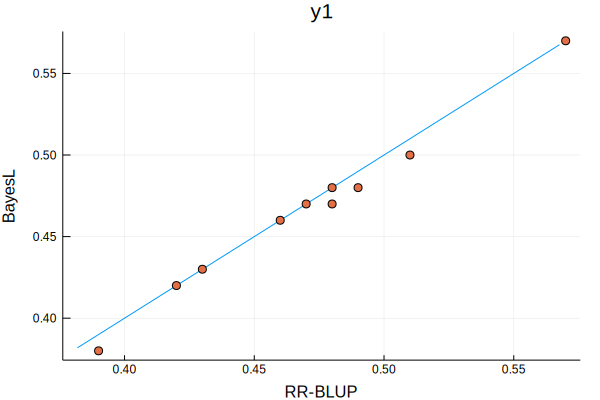

In [32]:
plot(x->x,minVal,maxVal,lab="",title="y1")
scatter!(resCorr[:,3],resCorr[:,1],xlabel="RR-BLUP",ylabel="BayesL",lab="")

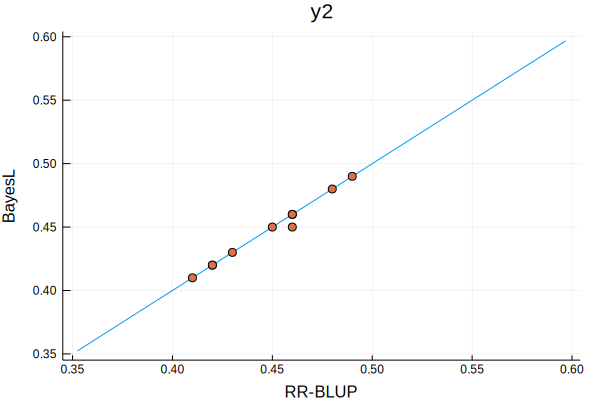

In [33]:
plot(x->x,0.35,0.6,title="y2",lab="")
scatter!(resCorr[:,4],resCorr[:,2],xlabel="RR-BLUP",ylabel="BayesL",lab="")

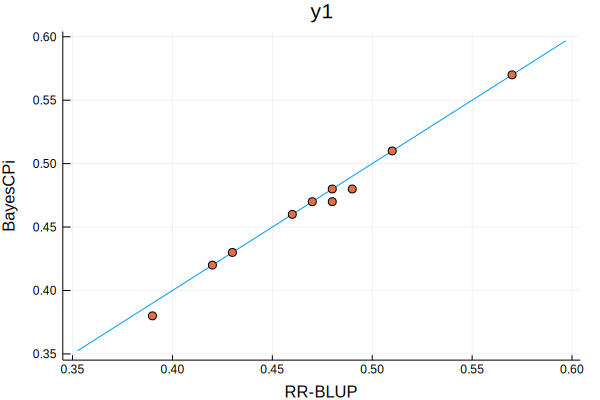

In [34]:
plot(x->x,0.35,0.6,title="y1",lab="")
scatter!(resCorr[:,3],resCorr[:,5], xlabel="RR-BLUP",ylabel="BayesCPi",lab="")

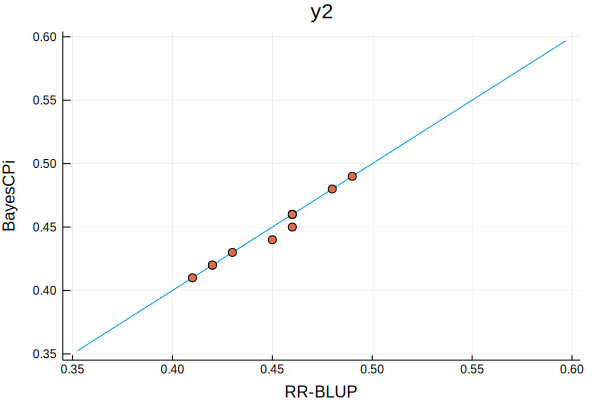

In [35]:
plot(x->x,0.35,0.6,title="y2",lab="")
scatter!(resCorr[:,4],resCorr[:,6], xlabel="RR-BLUP",ylabel="BayesCPi",lab="")

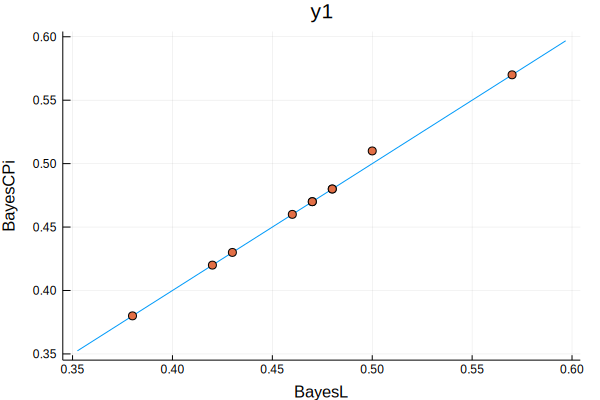

In [36]:
plot(x->x,0.35,0.6,title="y1",lab="")
scatter!(resCorr[:,1],resCorr[:,5], xlabel="BayesL",ylabel="BayesCPi",lab="")

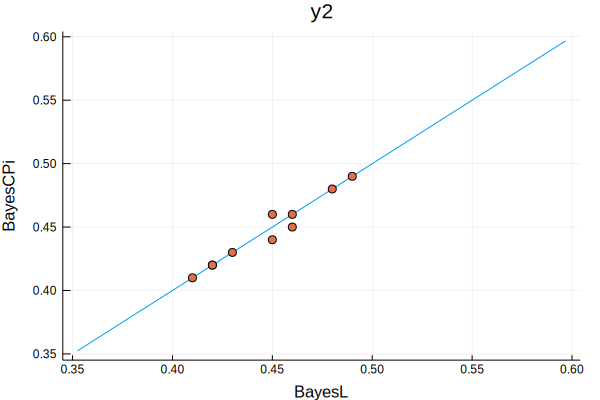

In [37]:
plot(x->x,0.35,0.6,title="y2",lab="")
scatter!(resCorr[:,2],resCorr[:,6], xlabel="BayesL",ylabel="BayesCPi",lab="")